Compares performance off the shelf methods to fine tuning methods in terms of accuracy/computation time
tradeoff.

Will likely not use this in the paper tho :-( At best in the appendix

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ots_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ots_type"
ft_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ft_type"
target_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ots_vs_ft"
dataset = "type"

models = {
    "vit_": {"vit": True},
    "swin_": {"vit": True},
    "beit_": {"vit": True},
    "deit_": {"vit": True},
    "vgg19": {"vit": False},
    "resnet50": {"vit": False},
    "efficientnetv2_": {"vit": False},
    "convnext_": {"vit": False}
}

In [3]:
for model in models:
    for method, folder in zip(["ots", "ft"], [ots_dir, ft_dir]):
        df = pd.read_csv(os.path.join(folder, "durations.csv"))
        models[model][f"{method}_dur"] = float(df[df["model"].str.find(model) >= 0]["time_mean"])
        models[model][f"{method}_dur_std"] = float(df[df["model"].str.find(model) >= 0]["time_std"])

        models[model][f"{method}_epoch_dur"] = float(df[df["model"].str.find(model) >= 0]["epoch_time_mean"])
        models[model][f"{method}_epoch_dur_std"] = float(df[df["model"].str.find(model) >= 0]["epoch_time_std"])

        df = pd.read_csv(os.path.join(folder, "test-stats.csv"))
        models[model][f"{method}_acc"] = float(df[df["model"].str.find(model) >= 0]["accuracy_mean"])
        models[model][f"{method}_acc_std"] = float(df[df["model"].str.find(model) >= 0]["accuracy_std"])

# I really dropped the ball on coding here XD
for method, folder in zip(["ots", "ft"], [ots_dir, ft_dir]):
    for file in os.scandir(folder):
        if file.is_file():
            for model in models:
                if model in file.name:
                    models[model][f"{method}_val"] = pd.read_csv(file.path)["mean_acc"].to_numpy() + 0 * pd.read_csv(file.path)["std_acc"].to_numpy()
                    break

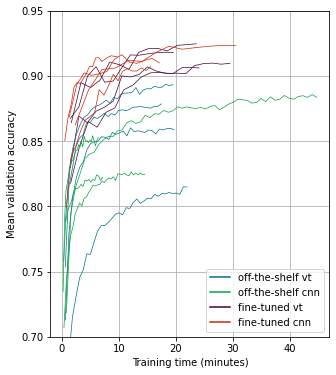

In [4]:
ots_vit = "#007187"
ots_cnn = "#05a344"
ft_vit = "#420136"
ft_cnn = "#d12506"

def accAgainstTime(acc, epoch_time, col):
    x = [(epoch_time / 60) * (1 + ep) for ep in range(len(acc))]
    plt.plot(x, acc, color=col, linewidth=0.7)

for model in models:
    color = ots_vit if models[model]["vit"] else ots_cnn
    accAgainstTime(models[model]["ots_val"], models[model]["ots_epoch_dur"], color)

    color = ft_vit if models[model]["vit"] else ft_cnn
    accAgainstTime(models[model]["ft_val"], models[model]["ft_epoch_dur"], color)

plt.grid()
plt.xlabel("Training time (minutes)")
plt.ylabel("Mean validation accuracy")
plt.ylim(top=.95, bottom=0.7)

fig = plt.gcf()
fig.set_size_inches(5, 6)

forlegend = [
    plt.Line2D([0], [0], color=ots_vit, label="off-the-shelf vt"),
    plt.Line2D([0], [0], color=ots_cnn, label="off-the-shelf cnn"),
    plt.Line2D([0], [0], color=ft_vit, label="fine-tuned vt"),
    plt.Line2D([0], [0], color=ft_cnn, label="fine-tuned cnn")
]
plt.legend(handles=forlegend)

# plt.show()
plt.savefig(os.path.join(target_dir, f"val_acc_vs_time_{dataset}.svg"), format="svg")

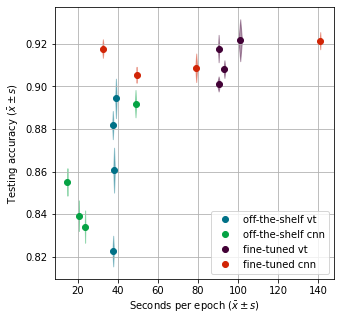

In [5]:
def markDot(x, y, x_std, y_std, col):
    plt.plot([x], [y], marker="o", color=col)

    x_err = [x - x_std, x, x + x_std]
    y1_err = [y, y + y_std, y]
    y2_err = [y, y - y_std, y]

    plt.fill_between(x_err, y1=y1_err, y2=y2_err, alpha=0.4, color=col)

for model in models:
    color = ots_vit if models[model]["vit"] else ots_cnn
    markDot(models[model]["ots_epoch_dur"], models[model]["ots_acc"], models[model]["ots_epoch_dur_std"], models[model]["ots_acc_std"], color)

    color = ft_vit if models[model]["vit"] else ft_cnn
    markDot(models[model]["ft_epoch_dur"], models[model]["ft_acc"], models[model]["ft_epoch_dur_std"], models[model]["ft_acc_std"], color)

plt.grid()
plt.xlabel(r"Seconds per epoch ($\bar{x} \pm s$)")
plt.ylabel(r"Testing accuracy ($\bar{x} \pm s$)")

fig = plt.gcf()
fig.set_size_inches(5, 5)

forlegend = [
    plt.Line2D([0], [0], color=ots_vit, label="off-the-shelf vt", marker="o", linewidth=0.0),
    plt.Line2D([0], [0], color=ots_cnn, label="off-the-shelf cnn", marker="o", linewidth=0.0),
    plt.Line2D([0], [0], color=ft_vit, label="fine-tuned vt", marker="o", linewidth=0.0),
    plt.Line2D([0], [0], color=ft_cnn, label="fine-tuned cnn", marker="o", linewidth=0.0)
]
plt.legend(handles=forlegend)

# plt.show()
plt.savefig(os.path.join(target_dir, f"test_acc_vs_epoch_time_{dataset}.svg"), format="svg")